In [1]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from pathlib import Path

image_path = Path("data/pizza_steak_sushi")

train_dir = image_path / "train"

test_dir = image_path / "test"

In [4]:
import os

for dirpath, dirs, files in os.walk(train_dir):
    print(f"There are {len(dirs)} folder and {len(files)} files in {dirpath}")

There are 3 folder and 0 files in data\pizza_steak_sushi\train
There are 0 folder and 78 files in data\pizza_steak_sushi\train\pizza
There are 0 folder and 75 files in data\pizza_steak_sushi\train\steak
There are 0 folder and 72 files in data\pizza_steak_sushi\train\sushi


In [5]:
simple_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.ToDtype(torch.float32,scale=True)
])

In [6]:
train_data = ImageFolder(train_dir,simple_transform)
test_data = ImageFolder(test_dir, simple_transform)

In [7]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(
    test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

In [9]:
train_dataloader.batch_size

32

In [10]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [11]:
img,label = next(iter(train_dataloader))


In [12]:
img.shape,label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [13]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3,1,1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 16 * 16,output_shape)
        )

    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [14]:
model_0 = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [15]:
from torchinfo import summary

summary(model_0,input_size=(32,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [16]:
img_single = img[0].unsqueeze(0).to(device)
label_single = label[0]

In [17]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(img_single)

    print(f"Logits: {y_logits}")
    print(f"Pred Probs: {torch.softmax(y_logits,dim=1)}")
    print(f"Pred Label: {torch.softmax(y_logits,dim=1).argmax(dim=1)}")
    print(f"True label: {label_single}")

Logits: tensor([[0.0203, 0.0224, 0.0080]], device='cuda:0')
Pred Probs: tensor([[0.3345, 0.3352, 0.3304]], device='cuda:0')
Pred Label: tensor([1], device='cuda:0')
True label: 1


In [18]:
from torchmetrics.classification import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [19]:
def train_step(data_loader:torch.utils.data.Dataset,model:nn.Module,loss_fn:nn.Module,optimizer:torch.optim.Optimizer,device=device):
    model.train()

    train_loss = 0
    acc_fn.reset()

    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)

        y_logits = model(X)
        y_preds = torch.argmax(y_logits,dim=1)

        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        acc_fn.update(y_preds,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc = acc_fn.compute()
   
    return train_loss,train_acc

In [20]:
def test_step(data_loader:torch.utils.data.DataLoader,model:nn.Module,loss_fn:nn.Module,device=device):
    model.eval()

    test_loss = 0
    acc_fn.reset()
    with torch.inference_mode():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)

            y_logits = model(X)
            y_preds = torch.argmax(y_logits, dim=1)

            loss = loss_fn(y_logits,y)
            test_loss += loss.item()
            acc_fn.update(y_preds,y)

        test_acc = acc_fn.compute()
    test_loss /= len(data_loader)

    return test_loss,test_acc

In [21]:
def train_model(model:nn.Module,optimizer:torch.optim.Optimizer,train_dataloader:torch.utils.data.DataLoader,test_dataloader: torch.utils.data.DataLoader,loss_fn:nn.Module=nn.CrossEntropyLoss(),epochs:int=5,device=device):

    model.to(device)

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch: {epoch} ")
        train_loss, train_acc = train_step(
            train_dataloader, model, loss_fn=nn.CrossEntropyLoss(), optimizer=optimizer
        )
        test_loss,test_acc = test_step(test_dataloader, model, loss_fn,device)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        results["train_loss"].append(torch.tensor(train_loss).cpu().item())
        results["train_acc"].append(train_acc.item())
        results["test_loss"].append(torch.tensor(test_loss).cpu().item())
        results["test_acc"].append(test_acc.item())
    return results

In [22]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data.classes))
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()

model_0_results = train_model(
    model=model_0,optimizer=optimizer,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=nn.CrossEntropyLoss(),device=device,epochs=5
)

end_time = timer()

print(f"Time taken is {(end_time - start_time):.4f}")


Epoch: 0 
Train Loss: 1.1078 | Train Accuracy: 0.2933
Test Loss: 1.1362 | Test Acc: 0.3333

Epoch: 1 
Train Loss: 1.0846 | Train Accuracy: 0.3467
Test Loss: 1.1622 | Test Acc: 0.2533

Epoch: 2 
Train Loss: 1.1154 | Train Accuracy: 0.3333
Test Loss: 1.1697 | Test Acc: 0.2533

Epoch: 3 
Train Loss: 1.0983 | Train Accuracy: 0.3333
Test Loss: 1.1348 | Test Acc: 0.2533

Epoch: 4 
Train Loss: 1.0990 | Train Accuracy: 0.3333
Test Loss: 1.1430 | Test Acc: 0.2533
Time taken is 70.8002


In [23]:
model_0_results

{'train_loss': [1.1078368425369263,
  1.0846331119537354,
  1.1154340505599976,
  1.0982893705368042,
  1.099021553993225],
 'train_acc': [0.2933333218097687,
  0.3466666638851166,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408],
 'test_loss': [1.1362193822860718,
  1.162177324295044,
  1.1696968078613281,
  1.1348302364349365,
  1.142950415611267],
 'test_acc': [0.3333333432674408,
  0.25333333015441895,
  0.25333333015441895,
  0.25333333015441895,
  0.25333333015441895]}

In [41]:
import matplotlib.pyplot as plt
from typing import Dict,List


def plot_loss_curves(results: Dict[str, List[float]]):

    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(epochs,train_loss,label="Train")
    plt.plot(epochs, test_loss,label="Test")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(epochs, train_acc,label="Train")
    plt.plot(epochs, test_acc,label="Test")
    plt.xlabel("Epoch")
    plt.legend()

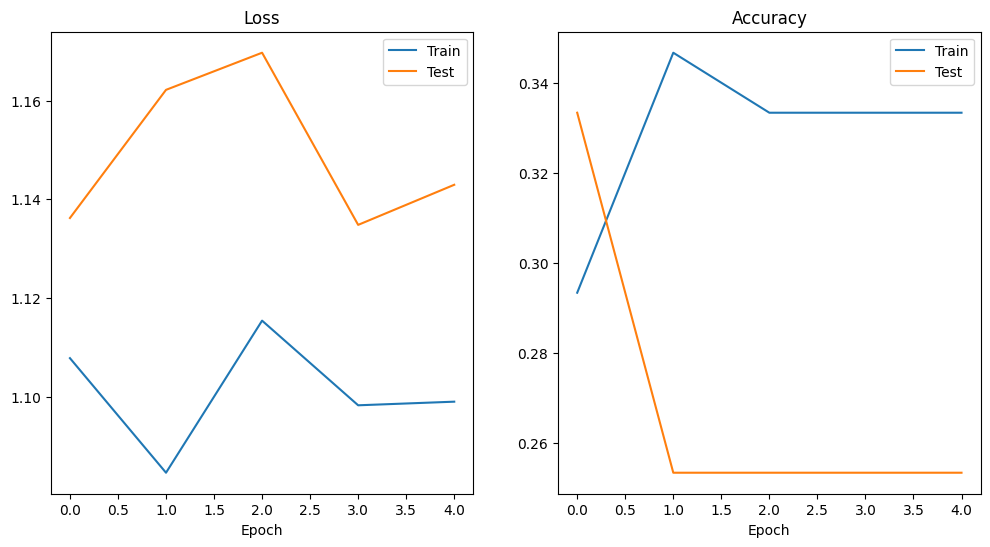

In [42]:
plot_loss_curves(model_0_results)

In [26]:
train_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.ToDtype(dtype=torch.float32,scale=True)
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(64,64)),
    v2.ToDtype(dtype=torch.float32,scale=True)
])

In [27]:
from  torchvision.datasets import ImageFolder
train_data = ImageFolder(root=train_dir,transform=train_transform)
test_data = ImageFolder(root=test_dir,transform=test_transform)

In [28]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,batch_size=32,num_workers=NUM_WORKERS,shuffle=True)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=32, num_workers=NUM_WORKERS
)


In [29]:
model_1 = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data.classes)).to(device)

In [30]:
from torchinfo import summary

summary(model=model_1,input_size=(32,3,64,64),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),lr=0.001)

model_1_results = train_model(model=model_1,optimizer=optimizer,loss_fn=loss_fn,train_dataloader=train_dataloader,test_dataloader=test_dataloader,epochs=5,device=device)


Epoch: 0 
Train Loss: 1.1059 | Train Accuracy: 0.2844
Test Loss: 1.1001 | Test Acc: 0.3333

Epoch: 1 
Train Loss: 1.0823 | Train Accuracy: 0.3467
Test Loss: 1.1253 | Test Acc: 0.3333

Epoch: 2 
Train Loss: 1.0798 | Train Accuracy: 0.3467
Test Loss: 1.1564 | Test Acc: 0.3333

Epoch: 3 
Train Loss: 1.1255 | Train Accuracy: 0.3467
Test Loss: 1.1611 | Test Acc: 0.3333

Epoch: 4 
Train Loss: 1.0895 | Train Accuracy: 0.3467
Test Loss: 1.1533 | Test Acc: 0.3333


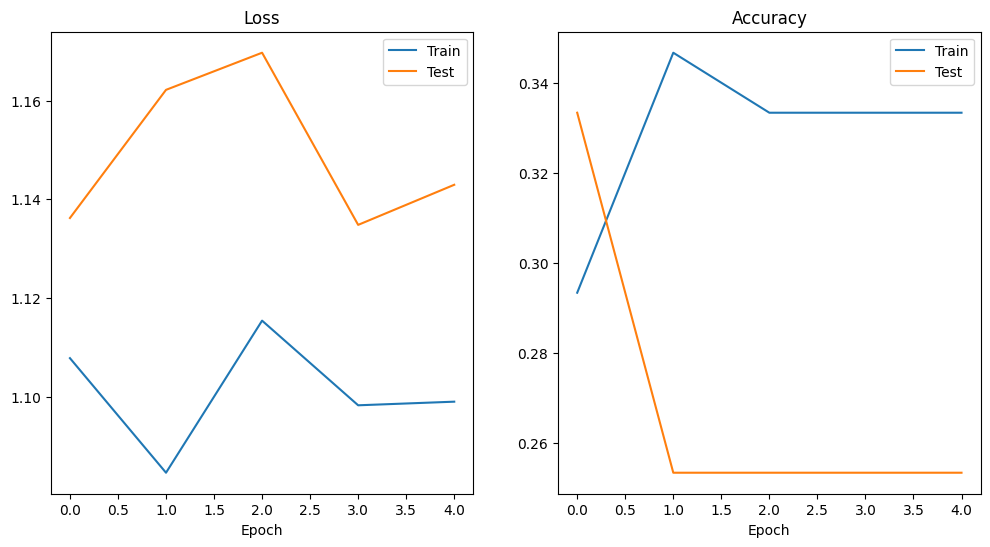

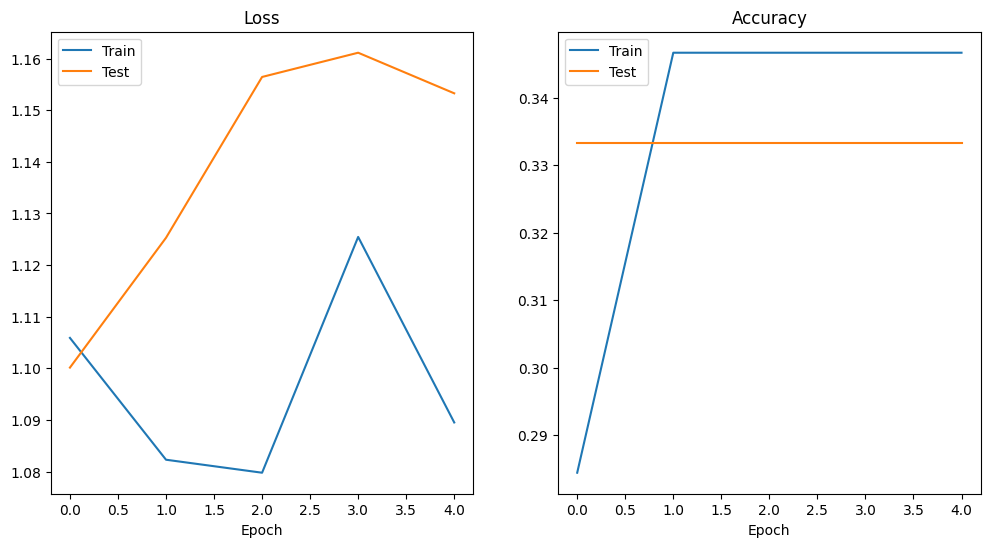

In [43]:
plot_loss_curves(model_0_results)
plot_loss_curves(model_1_results )

In [44]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.105889,0.284444,1.100133,0.333333
1,1.082283,0.346667,1.125289,0.333333
2,1.079765,0.346667,1.156449,0.333333
3,1.125453,0.346667,1.161146,0.333333
4,1.089503,0.346667,1.153281,0.333333


In [53]:
def compare_model(results_0: Dict[str, List[str]], results_1: Dict[str, List[str]]):

    epochs = range(len(results_0["train_loss"]))
    plt.figure(figsize=(12,6))
    
    plt.subplot(2,2,1)
    plt.title("Train Loss")
    plt.plot(epochs,results_0["train_loss"],label="model_0")
    plt.plot(epochs, results_1["train_loss"],label="model_1")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title("Train Acc")
    plt.plot(epochs, results_0["train_acc"],label="model_0")
    plt.plot(epochs, results_1["train_acc"],label="model_1")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.title("Test Loss")
    plt.plot(epochs, results_0["test_loss"],label="model_0")
    plt.plot(epochs, results_1["test_loss"],label="model_1")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.title("Test Acc")
    plt.plot(epochs, results_0["test_acc"],label="model_0")
    plt.plot(epochs, results_1["test_acc"],label="model_1")
    plt.legend()
    
    plt.tight_layout()

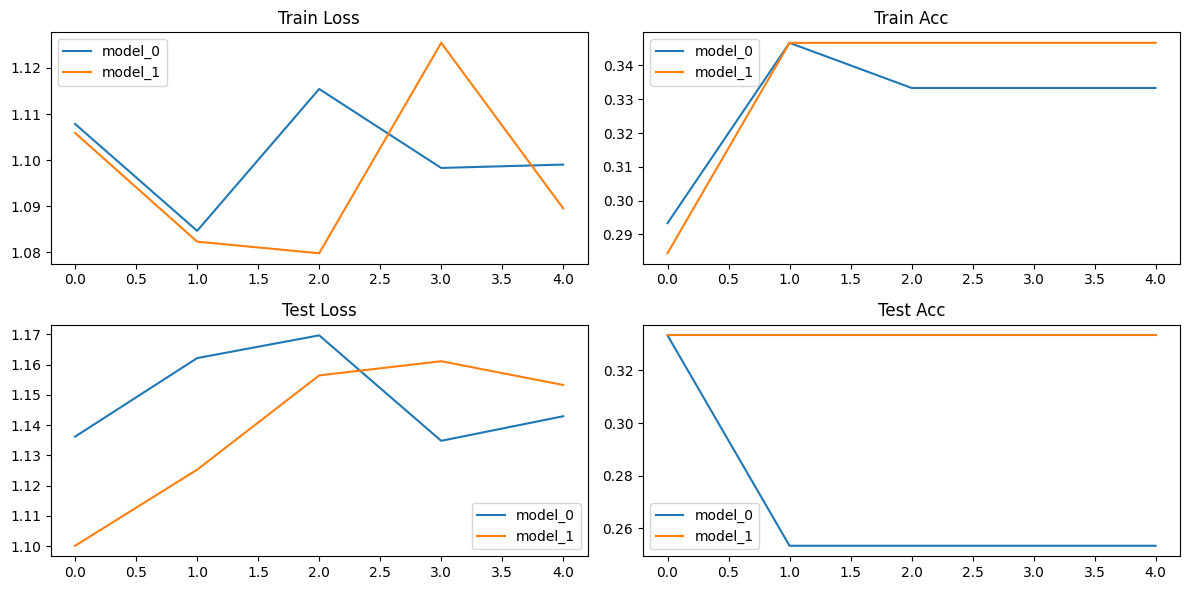

In [54]:
compare_model(model_0_results,model_1_results)